# Ghouls, Goblins, and Ghosts... Boo!

This is my first Kaggle competition and first try in machine learning. 

## 1 - Packages

In [1]:
from sklearn import preprocessing, ensemble, model_selection

import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 2 - Overview of the Dataset

Loading data:

In [3]:
train_data = pd.read_csv('train.csv', header=0, sep=',')
test_data = pd.read_csv('test.csv', header=0, sep=',')

Shape of datasets:

In [4]:
print('Shape of train data: ', train_data.shape)
print('Shape of test data: ', test_data.shape)

Shape of train data:  (371, 7)
Shape of test data:  (529, 6)


First 5 rows of datasets:

In [5]:
train_data.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [6]:
test_data.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color
0,3,0.471774,0.387937,0.706087,0.698537,black
1,6,0.427332,0.645024,0.565558,0.451462,white
2,9,0.549602,0.491931,0.660387,0.449809,black
3,10,0.638095,0.682867,0.471409,0.356924,white
4,13,0.361762,0.583997,0.377256,0.276364,black


Check column names:

In [7]:
print('Column names:', list(train_data.columns))

Column names: ['id', 'bone_length', 'rotting_flesh', 'hair_length', 'has_soul', 'color', 'type']


Remove id columns from datasets as it won't be used:

In [8]:
train_data = train_data.drop(['id'], axis=1)

test_id = test_data['id']
test_data = test_data.drop(['id'], axis=1)

Visualising train dataset as a pairplot. Represents float values of columns 'bone_length', 'rotting_flesh', 'hair_length', 'has_soul'.

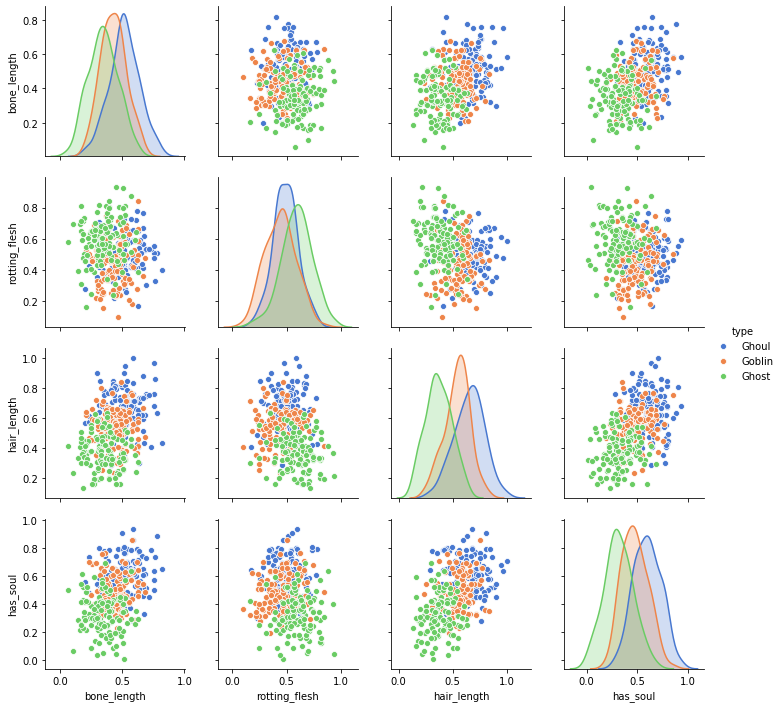

In [9]:
sns.pairplot(train_data.drop('color', axis = 1), hue = 'type', palette = 'muted', diag_kind='kde')

Dataset contains categorical value column 'color'. Let's visualise it.

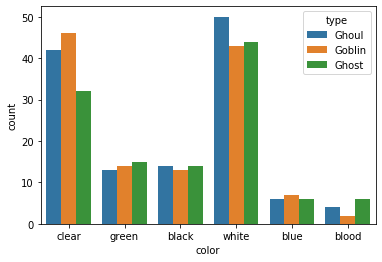

In [10]:
sns.countplot(x='color', hue='type', data=train_data)

Compare general amount of samples to classify for each value.

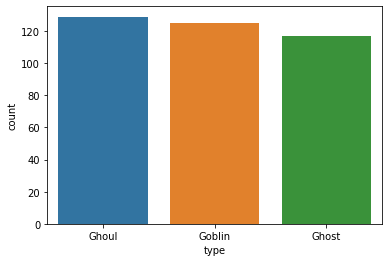

In [11]:
sns.countplot(x='type', data=train_data)

Next we are splitting data to target and features sets. Let's apply label encoding for target values(replace string values by int) in target set and for 'color' column in feature set.

In [12]:
color_le = preprocessing.LabelEncoder()

train_data_x = train_data
color_le.fit(train_data_x['color'])
train_data_x['color_int'] = color_le.transform(train_data_x['color'])
train_data_x = train_data_x.drop(['color', 'type'], axis=1)
train_data_x = train_data_x.to_numpy()

type_le = preprocessing.LabelEncoder()

train_data_y = train_data['type']
type_le.fit(train_data_y)
train_data_y = type_le.transform(train_data_y)

print('Unique type values:', train_data.type.unique())
print()
print('Original train_set_y:', np.array(train_data.type[:5]))
print('Encoded train_set_y:', train_data_y[:5])

Unique type values: ['Ghoul' 'Goblin' 'Ghost']

Original train_set_y: ['Ghoul' 'Goblin' 'Ghoul' 'Ghoul' 'Ghost']
Encoded train_set_y: [1 2 1 1 0]


Preprocessing test data for final prediction is the same as for train_data_x.

In [13]:
test_data = test_data
color_le.fit(test_data['color'])
test_data['color_int'] = color_le.transform(test_data['color'])
test_data = test_data.drop(['color'], axis=1)
test_data = test_data.to_numpy()

Preprocessed test data looks like:

In [14]:
print('test_data:')
print(test_data[:5])

test_data:
[[0.47177445 0.38793706 0.70608662 0.69853726 0.        ]
 [0.42733226 0.64502359 0.56555791 0.45146162 5.        ]
 [0.54960189 0.49193055 0.66038749 0.44980918 0.        ]
 [0.63809497 0.68286744 0.47140899 0.35692448 5.        ]
 [0.36176224 0.58399739 0.3772565  0.27636395 0.        ]]


Final train x and y sets look like:

In [15]:
print('train_data_x:')
print(train_data_x[:5])
print('shape:', train_data_x.shape, 'type:', type(train_data_x))
print()
print('train_data_y:')
print(train_data_y[:5])
print('shape:', train_data_y.shape, 'type:', type(train_data_y))

train_data_x:
[[0.35451218 0.35083903 0.46576089 0.78114167 3.        ]
 [0.57555991 0.42586843 0.53140138 0.43989888 4.        ]
 [0.4678755  0.35433042 0.81161609 0.79122497 0.        ]
 [0.77665246 0.50872255 0.63676558 0.88446369 0.        ]
 [0.5661166  0.8758618  0.41859367 0.63643782 4.        ]]
shape: (371, 5) type: <class 'numpy.ndarray'>

train_data_y:
[1 2 1 1 0]
shape: (371,) type: <class 'numpy.ndarray'>


## 3 - Model

In this project I am going to use Random Forest Classifier to classify types of creatures. We need to determine hyperparameter - number of trees in forest. Let's look through range of numbers 1, 5, ... 50. We will use cross validation with 3 foldes to find the best parameter.

In [16]:
n_trees = [1] + list(range(5, 55, 5))
scoring = []
for n_tree in n_trees:
    estimator = ensemble.RandomForestClassifier(n_estimators = n_tree, min_samples_split=5, random_state=1)
    score = model_selection.cross_val_score(estimator, train_data_x, train_data_y, 
                                             scoring = 'accuracy', cv = 3)    
    scoring.append(score)
scoring = np.asmatrix(scoring)

scoring

matrix([[0.57258065, 0.59677419, 0.53658537],
        [0.62096774, 0.68548387, 0.69918699],
        [0.70967742, 0.71774194, 0.73170732],
        [0.72580645, 0.70967742, 0.73170732],
        [0.72580645, 0.73387097, 0.75609756],
        [0.71774194, 0.7016129 , 0.72357724],
        [0.72580645, 0.69354839, 0.69918699],
        [0.73387097, 0.7016129 , 0.71544715],
        [0.71774194, 0.70967742, 0.69918699],
        [0.72580645, 0.71774194, 0.72357724],
        [0.74193548, 0.71774194, 0.72357724]])

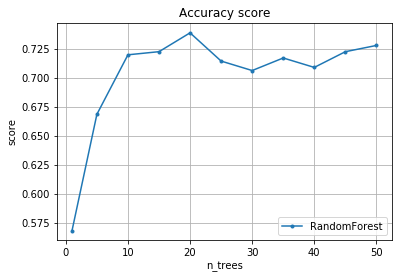

In [17]:
pylab.plot(n_trees, scoring.mean(axis = 1), marker='.', label='RandomForest')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('Accuracy score')
pylab.legend(loc='lower right')

Alternate way to find best value of hyperparameter is to use GridSearchCV:

In [18]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': n_trees}

grid_search = GridSearchCV(ensemble.RandomForestClassifier(min_samples_split=5, random_state=1), params, cv=3, scoring='accuracy')

grid_search.fit(train_data_x, train_data_y)

print('Best n of trees: {}, best accuracy score: {}'.format(grid_search.best_params_['n_estimators'], grid_search.best_score_))

Best n of trees: 20, best accuracy score: 0.738544474393531


It's clearly seen, that both searches have the same results. So, we will use 20 trees for Random Forest Classifier. Now we will divide train data into train and test sets for our model.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

train_set_x, test_set_x, train_set_y, test_set_y = train_test_split(train_data_x, train_data_y, test_size=0.33, random_state=42)

Now let's fit our model and predict y for test set. Then calculate accuracy score for test set.

In [20]:
best_n_tree = grid_search.best_params_['n_estimators']
model = ensemble.RandomForestClassifier(n_estimators = n_tree, min_samples_split=5, random_state=1)
model.fit(train_set_x, train_set_y)
pred_y = model.predict(test_set_x)

score = accuracy_score(test_set_y, pred_y)
print('Accuracy score:', score)

Accuracy score: 0.7154471544715447


Finally, let's predict the 'type' variable for test_data.

In [21]:
test_pred = model.predict(test_data)
encoded_test_pred = type_le.inverse_transform(test_pred)
print('Test predictions:', encoded_test_pred[:5])

Test predictions: ['Ghoul' 'Goblin' 'Ghoul' 'Ghost' 'Ghost']


In [22]:
submission = pd.DataFrame({'id': test_id, 'type':encoded_test_pred})
submission.to_csv('submission.csv', index=False)